In [11]:
## SIMULATION PARAMETERS
verbosity         = 8        # Set debug print statement verbosity level (0 = Standard, -1 = Off)
use_mass_units    = True     # Toggle whether calculations / results are given in units of pi-axion mass (True) or eV (False)
use_natural_units = True     # Toggle whether calculations / results are given in c = h = G = 1 (True) or SI units (False)   || NOTE: full SI/phsyical unit support is still WIP
save_output_files = True     # Toggle whether or not the results from this notebook run are written to a data directory
save_plots        = True     # Toggle whether or not to generate and save plots
use_logsumexp     = True     # Toggle whether or not numerical integrations are performed in log-scale number space (increases computation time)

## CONFIG PARAMETERS
config_name = "piaxiverse_main1"   # Descriptive name for the given parameter case. Output files will be saved in a directory with this name.
seed = None
#seed = 269934808235809364794393739371438879116                      # rng_seed, integer value (None for random)
#seed = 191281265662032962853842089260008419904
num_cores = 100              # Number of parallel threads available
method = "BDF"               # numerical integration method, to be passed to scipy.solve_ivp()

## Scenario to run
# NOTE: (NAME) indicates NAME is an alias of the previously listed item.
scenario = "SU3"           # one of: SINGLE, QCD, (AXION), SIMPLE, FULL, SU3, SU6, (SAMPLED), REALS, NEUTRALS, COMPLEX, CHARGED

In [12]:
#%cd ~/projects/pi-axiverse/

In [13]:
#%load piaxiverse.py

In [14]:
#%module load miniconda3/23.11.0s
#%module load texlive
#%source /oscar/runtime/software/external/miniconda3/23.11.0/etc/profile.d/conda.sh
#%conda activate piaxiverse

In [15]:
##### Optionally pregenerate a list of function calls for parameter space sampling
import numpy as np
param_list  = lambda x_range, x_num: np.linspace(x_range[0], x_range[1], num=x_num) if x_num > 1 else np.array([x_range[0]], dtype=np.float64)

# True  = call pyAxiverse main loop separately for each combination of parameters
# False = iterate through parameters within pyAxiverse main loop itself (WARNING: Potential OoM hangs/errors)
pregen_commands = True

# Toggle whether or not we scan over F_pi and m_quark, or g_pi and m_pi
# Toggle whether or not we enforce the misalignment angle g_pi-m_pi relation for a given millicharge
override_range_F = True
override_range_m = True
enforce_relation = False

# how many times to rerun a given input configuration, resampling any random variables
num_samples = 5

## (Log-scale) min and max ranges over which to sample

# Density [log GeV/cm^3]
density_range = [0, 40]        
density_num   = 9

# Dark quark mass scale [log eV]
qmass_range   = [-10, -80]
qmass_num     = 5

# Millicharge [log]
epsilon_range = [0, -30]
epsilon_num   = 5

# Pi-Axion decay constant [log GeV]
Fpi_range     = [0, 30]
Fpi_num       = 5

# Pi-Axion charged effective coupling [log GeV]
L3_range      = [0, 60]
L3_num        = 3

# Pi-Axion neutral effective coupling [log GeV]
#L4_range      = [0, 60]
#L4_num        = 3
L4_range      = [0, 30]
L4_num        = 7
#L4_range      = [11, 11]        
#L4_num        = 1

# Other tuneable constants
lambda_1 = 1

# Simulation bounds and granularity
num_times  = 1000   # Number of timesteps
max_tval   = 200    # Max time value (in time units)
num_kmodes = 100    # Number of k_modes
kmode_res  = 0.1    # k_mode step-size

In [ ]:
override_samples = (override_range_F and override_range_m) or enforce_relation

# Coupling constant and pi-axion mass ranges to sample (Toggleable)
g_pi_range = [-5, -30]   # [log GeV]
g_pi_num   = 9
m_pi_range = [-4, -8]     # [log eV]
m_pi_num   = 8

# Only include samples at indices which satisfy filtcon
#filtcon = lambda idx: idx % 2 == 1
filtcon = lambda idx: True

# Logic to handle whether or not we determine samples from g_pi and m_pi (observables) or F_pi and m_q (parameters of the theory)
if override_range_F or override_range_m or enforce_relation:
    from tools.pyaxi_utils import F_pi_from_g_x, m_x_from_g_x, g_x_from_F_pi
    m_q_from_m_x = lambda m_x, F, c1=1., c2=1.: (m_x**2)/((c1+c2)*(F*1e9))
    
    # For now, we assume epsilon to be static when we enforce these relations over a sampling range
    eps           = 1
    epsilon_range = [np.log10(eps), np.log10(eps)]       # Millicharge [log]
    epsilon_num   = 1

# Create lists of parameter ranges
density_list = [dens for idx, dens in enumerate(10**param_list(density_range, density_num)) if filtcon(idx)]
epsilon_list = 10**param_list(epsilon_range, epsilon_num)
L4_list      = 10**param_list(L4_range, L4_num)
L3_list      = 10**param_list(L3_range, L3_num)   # This will be disabled if there are no charged species
qmass_list   = 10**param_list(qmass_range, qmass_num)
Fpi_list     = 10**param_list(Fpi_range, Fpi_num)

# Override sample space selections if we want to instead sample relative to g_pi coupling or m_pi mass
if not override_range_F and (override_range_m or enforce_relation):
    Fpi_list = np.array([[F, eps] for F in Fpi_list for eps in epsilon_list], dtype=np.float64)
if override_range_F:
    # Calculate F_pi ranges given input millicharge and g_pi ranges
    g_pi_list = 10**param_list(g_pi_range, g_pi_num)

    Fpi_list  = np.array([[F_pi_from_g_x(g_x, l1=lambda_1, eps=eps), eps] for idx,g_x in enumerate(g_pi_list) for eps in epsilon_list if filtcon(idx)], dtype=np.float64)
    Fpi_num   = g_pi_num

    if override_range_m:
        override_samples = True
        m_pi_list  = 10**param_list(m_pi_range, m_pi_num)
        mf_list = np.array([[m_q_from_m_x(m_x, F=F), F, eps] for m_x in m_pi_list for F, eps in Fpi_list], dtype=np.float64)
        qmass_num = m_pi_num
elif override_range_m:
    # Calculate m_quark given input millicharge and m_pi ranges, for each F_pi
    m_pi_list  = 10**param_list(m_pi_range, m_pi_num)
    
    #qmass_list = np.array([m_q_from_m_x(m_x, F=10**np.mean(Fpi_range)) for m_x in m_pi_list], dtype=np.float64)
    mf_list    = np.array([[m_q_from_m_x(m_x, F=F), F, eps] for m_x in m_pi_list for F, eps in Fpi_list], dtype=np.float64)
    qmass_num  = m_pi_num

# Optionally also enforce that m_pi be subject to the same range as F_pi
if enforce_relation:
    override_samples = True
    #qmass_list = np.array([m_q_from_m_x(m_x_from_g_x(g_x_from_F_pi(F, l1=lambda_1, eps=eps), epsilon=eps, lambda1=lambda_1), F=F) for F in Fpi_list], dtype=np.float64)
    mf_list = np.array([[m_q_from_m_x(m_x_from_g_x(g_x_from_F_pi(F, l1=lambda_1, eps=eps), epsilon=eps, lambda1=lambda_1), F=F), F, eps] for F, eps in Fpi_list], dtype=np.float64)
    qmass_num  = g_pi_num

In [17]:
# Toggle whether calculations are performed in natural units (h=c=1) or physical units
# NOTE: Currently, natural units also requires unitless masses (and vice versa)
if use_mass_units or use_natural_units:
    PIAXI_UNITS = "--use_mass_units --use_natural_units"
else:
    PIAXI_UNITS = "--no-use_mass_units --no-use_natural_units"

# RNG seed
if seed is None:
    PIAXI_SEED = ""
else:
    PIAXI_SEED = f"--seed {seed} "

# Whether or not to save output files and plots
if save_plots:
    PIAXI_PLOTS = "--make_plots --no-show_plots"
else:
    PIAXI_PLOTS = "--no-make_plots --no-show_plots"
if save_output_files:
    PIAXI_SAVE  = f"--save_output_files {PIAXI_PLOTS}"
else:
    PIAXI_SAVE  = "--no-save_output_files --no-make_plots --no-show_plots"

if use_logsumexp:
    PIAXI_LOGSCALE="--use_logsumexp "
else:
    PIAXI_LOGSCALE=""

# Determine number of surviving pi-axion species and parameter distributions
PIAXI_JOB_SUFFIX = ""
PIAXI_FIT_F = ""
PIAXI_MASKS = ""
scenario_in = scenario.upper()
if scenario_in in ["EMPTY", "VACUUM"]: # (NOTE: May raise errors, not fully implemented)
    PIAXI_DQMC = "0 0 0 0 0 0"
    PIAXI_JOB_SUFFIX = "_vacuum"
elif scenario_in in ["0", None, "NONE", "NULL", "DEFAULT", ""]:
    PIAXI_DQMC = "1 1 1 0 0 0"
elif scenario_in in ["SINGLE"]:
    PIAXI_DQMC = "x x 0 0 0 0"
    PIAXI_JOB_SUFFIX = "_single"
elif scenario_in in ["QCD", "AXION", "QCD_AXION", "KSVZ"]:
    PIAXI_DQMC = "0.5 0.5 0 0 0 0"
    PIAXI_JOB_SUFFIX = "_qcd"
    PIAXI_FIT_F = "--fit_QCD"
    PIAXI_MASKS = "--mask_complex --mask_charged"
elif scenario_in in ["SIMPLE"]:
    PIAXI_DQMC = "1 1 1 0 0 0"
    PIAXI_JOB_SUFFIX = "_simple"
elif scenario_in in ["FULL", "DEGENERATE"]:
    PIAXI_DQMC = "1 1 1 1 1 1"
    PIAXI_JOB_SUFFIX = "_fully_degenerate"
elif scenario_in in ["SU3"]:
    PIAXI_DQMC = "x x x 0 0 0"
    PIAXI_JOB_SUFFIX = "_SU3"
elif scenario_in in ["SAMPLED", "SU6"]:
    PIAXI_DQMC = "x x x x x x"
    PIAXI_JOB_SUFFIX = "_SU6"
elif scenario_in in ["REALS", "AXIVERSE"]:
    PIAXI_DQMC = "x x x x x x"
    PIAXI_JOB_SUFFIX = "_reals"
    PIAXI_MASKS = "--mask_complex --mask_charged"
elif scenario_in in ["NEUTRALS", "ALL_NEUTRALS"]:
    PIAXI_DQMC = "x x x x x x"
    PIAXI_JOB_SUFFIX = "_neutrals"
    PIAXI_MASKS = "--mask_charged"
elif scenario_in in ["COMPLEX"]:
    PIAXI_DQMC = "x x x x x x"
    PIAXI_JOB_SUFFIX = "_complex"
    PIAXI_MASKS = "--mask_reals"
elif scenario_in in ["COMPLEX_NEUTRALS"]:
    PIAXI_DQMC = "x x x x x x"
    PIAXI_JOB_SUFFIX = "_complex_neutrals"
    PIAXI_MASKS = "--mask_reals --mask_charged"
elif scenario_in in ["CHARGED"]:
    PIAXI_DQMC = "x x x x x x"
    PIAXI_JOB_SUFFIX = "_charged"
    PIAXI_MASKS = "--mask_reals --mask_complex"

PIAXI_RES_ARGS = f"--t {max_tval} --tN {num_times} --kN {num_kmodes} --k_res {kmode_res}"
PIAXI_SYS_NAME = f"{config_name}{PIAXI_JOB_SUFFIX}"

In [18]:
import os

# Gather relevant args to pass to command line
PIAXI_INPUT_ARGS=f"--int_method {method} {PIAXI_SEED}{PIAXI_LOGSCALE}{PIAXI_UNITS} --verbosity {verbosity} {PIAXI_RES_ARGS} --config_name {PIAXI_SYS_NAME} {PIAXI_SAVE}"
#PIAXI_SLURM_ARGS=f"--num_cores {PIAXI_N_CORES} --num_nodes {PIAXI_N_NODES} --job_qos {PIAXI_JOB_QOS} --mem_per_core {PIAXI_COREMEM}"

# No need to sample L3 if there are never any charged species permitted in the subtheory or with any given millicharge values
L3_printlist = L3_list
if PIAXI_JOB_SUFFIX in ["_complex_neutrals", "_neutrals", "_reals", "_qcd"] or np.all(epsilon_list > 1e-10):
    L3_list = [1.]
    L3_printlist = 'N/A'

if override_samples:
    qmass_printlist = np.sort(np.array(list(set(mf_list[:,0])), dtype=np.float64))
    Fpi_printlist   = np.sort(np.array(list(set(mf_list[:,1])), dtype=np.float64))
elif override_range_F:
    Fpi_list = Fpi_list[:,0]

if verbosity >= 5:
    with np.printoptions(precision=1):
        print('Parameters to be simulated')
        print('--------------------------------------------------------------------')
        print('density: ', density_list)
        print('qmass: ', qmass_list) if not override_samples else print('*qmass: ', qmass_printlist)
        print('epsilon: ', epsilon_list) if not override_samples else print('*epsilon: ', epsilon_list)
        print('Fpi: ', Fpi_list) if not override_samples else print('*Fpi: ', Fpi_printlist)
        print('L3:  ', L3_printlist)
        print('L4:  ', L4_list)
        if override_samples:
            print('* == coupled by specified g_pi and m_pi ranges')
        print('--------------------------------------------------------------------')
#tot_count = np.prod([len(x) for x in [density_list, qmass_list, epsilon_list, Fpi_list, L3_list, L4_list]]) * num_samples
#print('Total number of function calls required:    N = %d' % tot_count)

if override_samples:
    argset = [(rho, qm, eps, Fpi, L3, L4) for rho in density_list for qm, Fpi, eps in mf_list for L3 in L3_list for L4 in L4_list for n in range(num_samples)]
else:
    argset = [(rho, qm, eps, Fpi, L3, L4) for rho in density_list for qm in qmass_list for eps in epsilon_list for Fpi in Fpi_list for L3 in L3_list for L4 in L4_list for n in range(num_samples)]

if verbosity >= 1:
    tot_count = len(argset)
    print('Total number of function calls required:    N = %d' % tot_count)

argfile_dir  = '~/scratch'
argfile_path = os.path.join(os.path.expanduser('~'), '/'.join(argfile_dir.split('/')[1:]), 'ARGFILES')
if not(os.path.exists(argfile_path)):
    os.makedirs(argfile_path)
argfile_name = os.path.join(argfile_path, PIAXI_SYS_NAME)

with open(argfile_name, 'w') as f:
    for rho_in, qm_in, eps_in, Fpi_in, L3_in, L4_in in argset:
        # Gather parameter space args to pass to command line
        PIAXI_DENSITY_ARGS = f"--rho {rho_in:.3e}"               # Density [GeV] || For QCD axion case ~ (amp_a)^2*m_a / 2
        PIAXI_F_ARGS = f"--F {Fpi_in:.3e} {PIAXI_FIT_F}"         # F_pi [GeV]    || For QCD axion case ~ 2/g_a
        PIAXI_M_ARGS = f"--m_scale {qm_in:.3e}"                  # m_I [eV]      || For QCD axion case ~ (m_a)^2 / F_pi
        PIAXI_L_ARGS = f"--L3 {L3_in:.3e} --L4 {L4_in:.3e}"      # Pi-Axiverse coupling constants: Lambda_3 and Lambda_4 [GeV]
        PIAXI_EPS_ARGS = f"--eps {eps_in:.3e}"                   # Millicharge (unitless)

        PIAXI_PARAM_ARGS=f"{PIAXI_DENSITY_ARGS} {PIAXI_F_ARGS} {PIAXI_M_ARGS} {PIAXI_L_ARGS} {PIAXI_EPS_ARGS} --dqm_c {PIAXI_DQMC} {PIAXI_MASKS}"

        f.write(f"python piaxiverse.py {PIAXI_INPUT_ARGS} {PIAXI_PARAM_ARGS} --no-skip_existing \n")

print('To sample this pi-axiverse parameter space, execute the following command: ')
print('\n')
scriptdir = os.path.join(os.path.expanduser('.'), '/'.join(['scripts','sample_pi_axiverse.sh']))
#print(f'      sbatch --array=1-{tot_count} --job-name={config_name}{PIAXI_JOB_SUFFIX}_array {scriptdir} {argfile_name}')
print(f'      sbatch --job-name={config_name}{PIAXI_JOB_SUFFIX}_array {scriptdir} {argfile_name} 1 {tot_count}')
print('\n')
print('--------------------------------------------------------------------')


Parameters to be simulated
--------------------------------------------------------------------
density:  [1.0, 100000.0, 10000000000.0, 1000000000000000.0, 1e+20, 1e+25, 1e+30, 1e+35, 1e+40]
*qmass:  [2.5e-56 3.5e-55 4.8e-54 3.3e-53 6.7e-53 4.6e-52 9.3e-52 6.4e-51 1.3e-50
 4.4e-50 8.9e-50 1.8e-49 6.2e-49 1.2e-48 2.5e-48 8.6e-48 1.7e-47 5.9e-47
 1.2e-46 2.4e-46 8.2e-46 1.7e-45 3.3e-45 1.1e-44 2.3e-44 7.9e-44 1.6e-43
 3.2e-43 1.1e-42 2.2e-42 4.4e-42 1.5e-41 3.1e-41 1.1e-40 2.1e-40 4.3e-40
 1.5e-39 2.9e-39 5.9e-39 2.0e-38 4.1e-38 1.4e-37 2.8e-37 5.7e-37 2.0e-36
 3.9e-36 7.9e-36 2.7e-35 5.5e-35 1.9e-34 3.8e-34 7.6e-34 2.6e-33 5.2e-33
 1.1e-32 3.6e-32 7.3e-32 2.5e-31 5.0e-31 1.0e-30 3.5e-30 7.0e-30 1.4e-29
 4.8e-29 9.7e-29 6.7e-28 1.3e-27 9.3e-27 1.9e-26 1.3e-25 1.8e-24 2.5e-23]
*epsilon:  [1.]
*Fpi:  [2.0e+05 2.7e+08 3.6e+11 4.7e+14 6.3e+17 8.4e+20 1.1e+24 1.5e+27 2.0e+30]
L3:   N/A
L4:   [1.e+00 1.e+05 1.e+10 1.e+15 1.e+20 1.e+25 1.e+30]
* == coupled by specified g_pi and m_pi ranges
---

                p_t           m_q      eps             F       L3  \
count  2.268000e+04  2.268000e+04  22680.0  2.268000e+04  22680.0   
mean   1.111122e+39  3.744300e-25      1.0  2.223890e+29      1.0   
std    3.142762e+39  2.930177e-24      0.0  6.284944e+29      0.0   
min    1.000000e+00  2.500000e-56      1.0  2.000000e+05      1.0   
25%    1.000000e+10  1.042695e-46      1.0  3.556559e+11      1.0   
50%    1.000000e+20  9.457622e-40      1.0  6.324555e+17      1.0   
75%    1.000000e+30  6.565941e-33      1.0  1.124683e+24      1.0   
max    1.000000e+40  2.500000e-23      1.0  2.000000e+30      1.0   

                 L4          g_pi           m_u  
count  2.268000e+04  2.268000e+04  2.268000e+04  
mean   1.428586e+29  1.111945e-06  1.708234e-05  
std    3.499342e+29  3.142472e-06  3.248350e-05  
min    1.000000e+00  1.000000e-30  1.000000e-08  
25%    1.000000e+05  1.778279e-24  1.135311e-07  
50%    1.000000e+15  3.162278e-18  1.224323e-06  
75%    1.000000e+25  5.62341

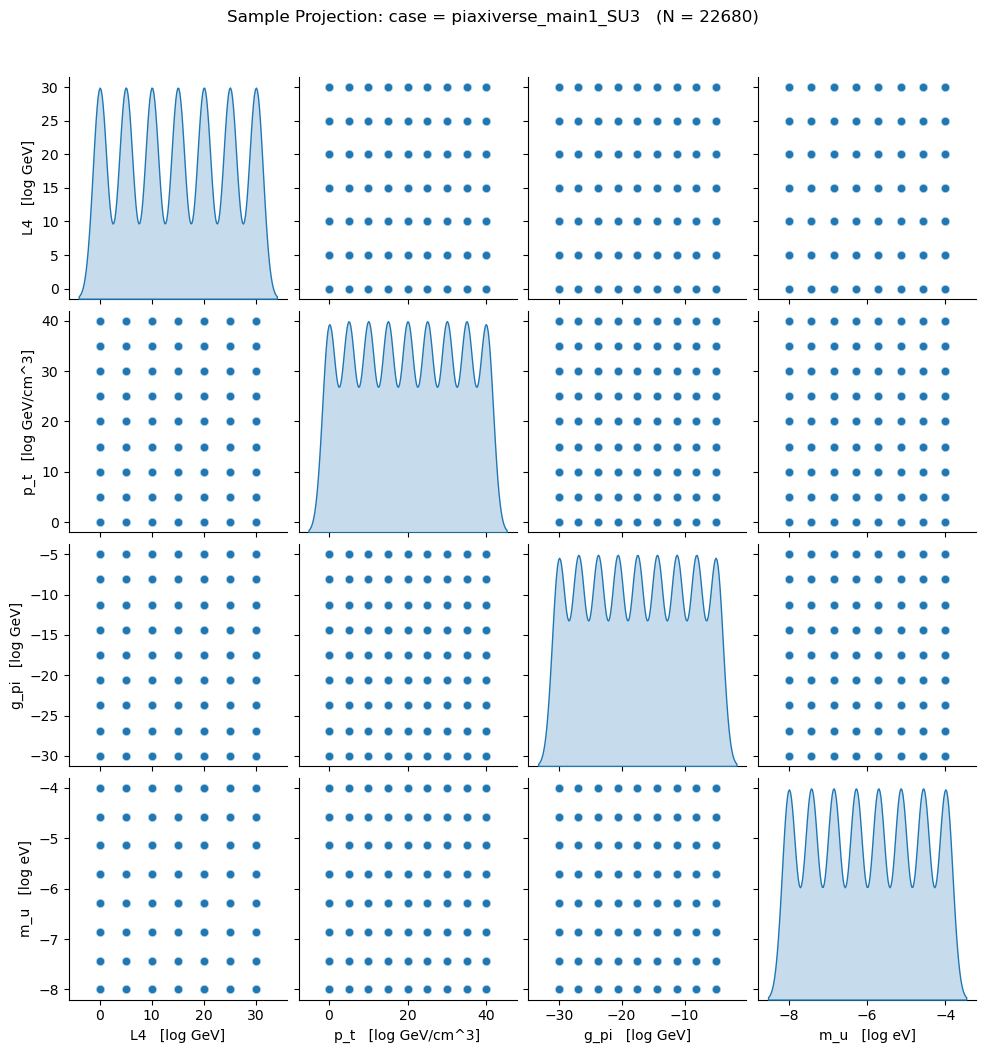

In [ ]:
# Example pairplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# temp fix for seaborn version
import warnings
warnings.filterwarnings('ignore')

pp_mode = 'scatter'      # 'kde', 'scatter', or 'mixed' pairplot display kinds

log_params  = ['p_0', 'p_t', 'F', 'L3', 'L4', 'm_q', 'g_pi', 'eps', 'res_ratio_f', 'res_ratio_m', 'm_0', 'k_0', 'm_u', 'qm_0', 'qm_1', 'qm_2', 'res_con', 'inf_con']
#log_params  += ['t_u']
dict_params = []
keep_params = ['res_class', 'config_name', 'units', 'res_band_class']
sampled_params = ['qc']

plot_params = ['F', 'L4', 'L3', 'm_q', 'p_t', 'eps']
fixed_params = {}

# Filter and rescale data for plotting
filter_nonunique  = True
filter_sampled    = True
rescale_logparams = True
infs_to_nans      = True

plot_data = pd.DataFrame(argset, columns=['p_t', 'm_q', 'eps', 'F', 'L3', 'L4'])

# Replace F_pi with g_pi and m_quark with m_pi, if that's what we're using to determine sample spacing
if override_samples or enforce_relation:
    from tools.pyaxi_utils import g_x_from_F_pi
    m_x_from_m_q = lambda m_q, F, c1=1., c2=1.: np.sqrt((c1+c2)*m_q*(F*1e9))

    if override_range_F:
        plot_params += ['g_pi']
        plot_params.remove('F')
        plot_data['g_pi'] = plot_data.apply(lambda x: g_x_from_F_pi(x['F'], l1=lambda_1, eps=x['eps']), axis=1)
    if override_range_m or (override_range_F and enforce_relation):
        plot_params += ['m_u']
        plot_params.remove('m_q')
        plot_data['m_u'] = plot_data.apply(lambda x: m_x_from_m_q(x['m_q'], x['F']), axis=1)

def drop_col(col_in, plot_data_in=plot_data, plot_params_in=plot_params):
    plot_data_in.drop(col_in, inplace=True, axis=1)
    if col_in in plot_params_in:
        plot_params_in.remove(col_in)

print(plot_data.describe())

if infs_to_nans:
    plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in plot_data.columns:
    if rescale_logparams and col in log_params:
        #print(col)
        plot_data[col] = np.log10(plot_data[col])
    if filter_sampled:
        if col in sampled_params and col not in keep_params:
            drop_col(col)
    if filter_nonunique:
        if len(plot_data[col].unique()) <= 1 and col not in keep_params:
            if col in plot_params:
                fixed_params[col] = plot_data[col].unique()[0]
                drop_col(col)

# Format color scheme
#hue_order = ['res_class']
#palette = {'resonance': 'purple', 'burst': 'orange', 'none': 'teal', 'damp': 'grey'}

# Format axes to show units
fmt_map = {'p_t': 'GeV/cm^3', 'm_u': 'eV', 'm_q': 'eV', 'g_pi': 'GeV','F': 'GeV', 'L3': 'GeV', 'L4': 'GeV', 'eps':''}
fmt_col = lambda c_in: '%s   %s' % (c_in, '' if (c_in not in log_params and (c_in not in fmt_map or fmt_map[c_in] == '')) else \
                                    '[%s%s]' % ('%s%s' % ('log' if c_in in log_params else '', ' ' if (c_in in fmt_map and fmt_map[c_in] != '') else ''), fmt_map[c_in]))
plot_data_units = plot_data.rename(columns={col: fmt_col(col) for col in plot_params})
plot_params_units = [fmt_col(col) for col in plot_params]

# kind = 'kde', 'scatter', 'hist', or 'reg'
conf_name = f'{config_name}{PIAXI_JOB_SUFFIX}'
pp_kws  = {'levels':5} if pp_mode == 'kde' else {'alpha':0.35}
pp_kind = pp_mode if pp_mode != 'mixed' else 'scatter'
pp = sns.pairplot(plot_data_units, x_vars=plot_params_units, y_vars=plot_params_units, dropna=True, kind=pp_kind, diag_kind='kde', plot_kws=pp_kws)
if pp_mode == 'mixed':
    pp.map_offdiag(sns.kdeplot, levels=4, hue_order=['res_class'], palette=palette)
pp.fig.suptitle('Sample Projection: case = %s   (N = %d)' % (conf_name, len(plot_data.index)), y=1.05)

if False:
    print('\nSimulation settings:')
    for key, val in fixed_params.items():
        if key in sim_settings_parameters:
            print('%20s :  %10s  [%s]' % (key, str(val), units_fmt(key)))

fixed_params_tuples = [(fp_key, fp_val) for fp_key, fp_val in fixed_params.items() if fp_key in plot_params]
if len(fixed_params_tuples) >= 1:
    print('Fixed params:')
    for key, val in fixed_params_tuples:
        print('%20s :  %10s  %s' % (key, str('%.1f' % val) if key in log_params else df_fmt(val, fmt=print_fmt[key]), units_fmt(key, prefix='log ' if key in log_params else '')))